## Step 3: Coregistration

In this step, we are going to connect the selected mineral deposits in Step 2 with the trench sample points we have generated in Step 1. The mineral deposits csv file contains only 5 columns -- index, longitude, latitude, age and plate id. These attributes are not enough for the machine learning analysis. In order to obtain features associated with the deposits, we need to connect these mineral deposits with the trench sample points. We call this process coregistration.

The coregistration method is simple. For a given mineral deposit, the coregistration process will try to find the nearest trench point within a certain region. If found, the subduction convergence kinematics statistics of the trench point will be associated with the mineral deposit. The attributes retrieved from the trench sample points will be used as input data for machine learning models later.

First, let's run the coregistration script and see what will happen. The coregistration script can be configurated via parameters.py, such as the input mineral deposits file, output file name and region of interest, etc.

Relevant parameters in [parameters.py](parameters.py):

* input_file
* output_dir
* regions
* vector_files
* grid_files


In [1]:
from parameters import parameters as p

#let's print out some of the parameters
#you can change the 'input_file' in parameters.py to use different mineral deposits. 
#Remember the files we have created in step 2?
print('The file name of the mineral deposits: ', p['input_file'])
print('The output folder: ', p['output_dir'])
print('The region of interest(in degree): ', p['regions'])
print('The subduction convergence kinematics statistics file name template: ', p['vector_files'])
print('\n')

import coregistration
#run the coregistration script
coregistration.main()
#some files should have been created at this point
#let's move to the next cell and check the results

The file name of the mineral deposits:  coregistration_input_data_example_155.csv
The output folder:  coreg_output
The region of interest(in degree):  [5, 10]
The subduction convergence kinematics statistics file name template:  ['./convergence_data/subStats_{time:.2f}.csv']


region of interest: 5
the length of input data is: 93690
region of interest: 10
the length of input data is: 6585
The coregistration output data have been saved in folder coreg_output successfully!
Time taken: 40.31080484390259  seconds


In [2]:
import pandas as pd
import Utils

#read in the coregistration output file
data = pd.read_csv("./coreg_output/0_vector_subStats.out", header=None) 
display(data.head())#let's print the first 5 rows

print('\nThe meaning of the columns: \n')
Utils.print_columns()

input_data = pd.read_csv(p['input_file'])
display(input_data)

#the input data and output data has the same length
print('The shape of the output data: ', data.shape)
print('The shape of the input data: ',input_data.shape)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-65.96,-28.02,0.09,803.0,-71.62,-27.24,10.11,-16.32,1.87,-94.20,...,-1.87,-10.66,-26.18,9.57,-4.70,59.50,0.16,111.16,2425.38,2.14
1,-52.99,-49.40,0.06,621.0,-57.95,-48.23,10.25,-53.17,3.53,-179.32,...,-0.04,-8.63,-72.27,2.63,-8.22,65.70,0.11,0.66,182.23,0.73
2,-68.95,-31.75,0.05,832.0,-72.10,-31.34,11.47,-12.68,2.42,-138.40,...,-1.61,-10.25,-23.73,9.38,-4.12,60.15,0.19,56.98,2306.09,2.18
3,-66.17,-28.26,0.09,852.0,-71.69,-27.75,10.10,-15.30,1.88,-93.16,...,-1.88,-10.66,-25.22,9.64,-4.54,65.26,0.17,97.17,2462.38,2.26
4,-66.19,-28.21,0.09,880.0,-71.67,-27.58,10.10,-15.64,1.88,-93.50,...,-1.88,-10.66,-25.54,9.62,-4.60,62.65,0.16,117.03,2382.27,2.16



The meaning of the columns: 

* 0 reconstructed mineral deposits longitude
* 1 reconstructed mineral deposits latitude
* 2 distance to the nearest trench point
* 3 the index of trench point
* 4 trench point longitude
* 5 trench point latitude
* 6 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
* 7 subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
* 8 trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
* 9 trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
* 10 length of arc segment (in degrees) that current point is on
* 11 trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
* 12 subducting plate ID
* 13 trench plate ID
* 14 distance (in degrees) along the trench line to the nearest trench edge
* 15 the distance (in degrees) along the trench line from the start edge 

,index,lon,lat,age,plate_id
0,0,-66.28,-27.37,6,201
1,1,-69.37,-31.30,230,201
2,2,-69.75,-30.50,12,201
3,3,-66.65,-27.27,9,201
4,4,-66.61,-27.33,8,201
...,...,...,...,...,...
93685,93685,-71.15,-56.49,229,201
93686,93686,-70.89,-56.56,229,201
93687,93687,-70.59,-56.65,229,201
93688,93688,-70.33,-56.71,229,201


The shape of the output data:  (93690, 29)
The shape of the input data:  (93690, 5)


We can see in above code cell that the input data and output data has the same length. It means, for each input mineral deposit, there is one corresponding data row in the output file. 

The coregistration program takes the mineral deposit coordinates and uses age and plate id to reconstruct the deposits back in time. And then the program searches the nearby subduction trench, if found, copy the subduction convergence kinematics statistics.

##### Now we plot some maps to see the attributes acquired from coregistration.

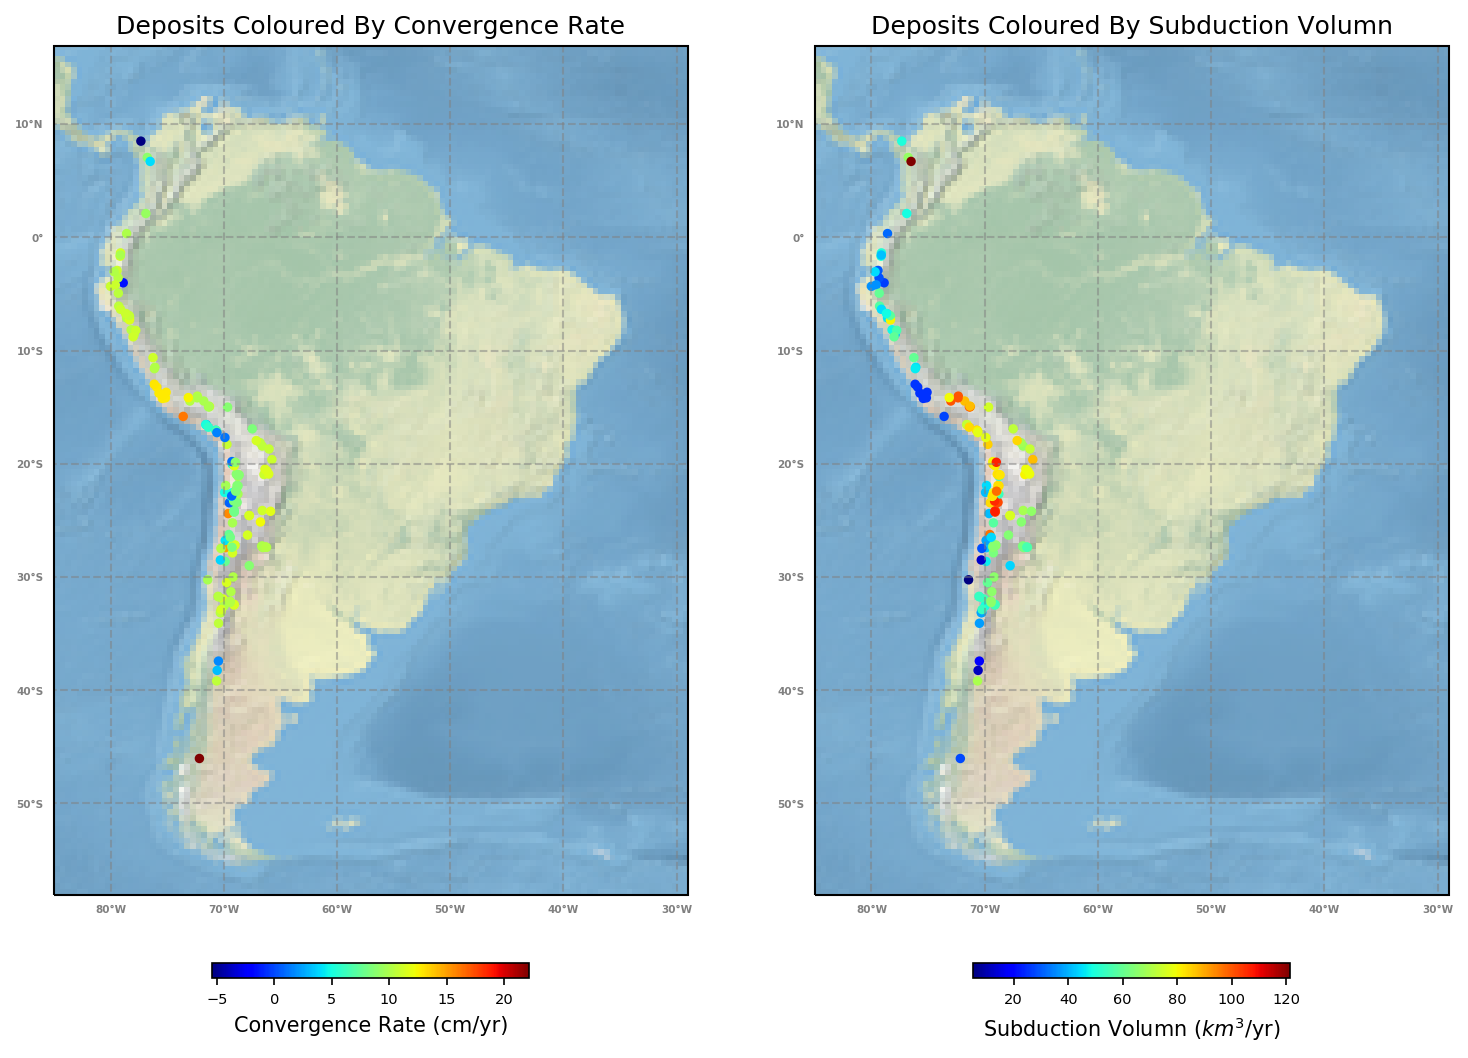

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def set_ax(ax):
    ax.stock_img()
    ax.set_extent([-85, -29, -55, 15])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -80, -70, -60,-50,-40,-30, 0, 180])
    gl.ylocator = mticker.FixedLocator([-90,-50,-40, -30, -20,-10, 0, 10, 20, 30, 40,50, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold', 'fontsize': '5'}

trench_file = './convergence_data/subStats_0.00.csv'
trench_data= np.genfromtxt(trench_file)

import re
deposit_len = int(re.split(r'_|\.', p['input_file'])[-2])

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,12),dpi=150)
set_ax(ax1)
set_ax(ax2)

cb_1 = ax1.scatter(input_data.loc[:deposit_len,'lon'], input_data.loc[:deposit_len,'lat'], 50, marker='.',
                c=data.loc[:deposit_len,6],  cmap=plt.cm.jet)
cb_2 = ax2.scatter(input_data.loc[:deposit_len,'lon'], input_data.loc[:deposit_len,'lat'], 50, marker='.',
                c=data.loc[:deposit_len,24],  cmap=plt.cm.jet)

ax1.title.set_text('Deposits Coloured By Convergence Rate')
ax2.title.set_text('Deposits Coloured By Subduction Volumn')
cbar_1 = fig.colorbar(cb_1, shrink=0.5, ax=[ax1], orientation='horizontal', pad=0.05)
cbar_1.set_label('Convergence Rate (cm/yr)',size=10)
cbar_1.ax.tick_params(labelsize=7)
cbar_2 = fig.colorbar(cb_2, shrink=0.5, ax=[ax2], orientation='horizontal', pad=0.05)
cbar_2.set_label('Subduction Volumn ($km^3$/yr)',size=10)
cbar_2.ax.tick_params(labelsize=7)
plt.show()

#### This is the end of step 3 and now open the step 4 notebook -- "4_Data_Wrangling.ipynb"